# Imports

In [17]:
# Imports
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

mpl_rc = "../assets/matplotlibrc"
plt.style.use(mpl_rc)

import numpy as np
import pandas as pd
import brian2 as b2
from torch import Tensor
from time import time

from automind.sim import b2_interface, runners, b2_models
from automind.inference import inferer
from automind.utils import data_utils, analysis_utils, dist_utils, plot_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from brian2 import *
import json

In [6]:
data_dirs = "../datasets/discovered_posterior_samples/synthetic/"
path_dict = data_utils.extract_data_files(
    data_dirs,
    [
        "posterior.pickle",
        "params_dict_analysis_updated.pickle",
        "summary_data_merged.csv",
    ],
)
df_xos, posterior, params_dict = data_utils.load_df_posteriors(path_dict)
_, _, _, _, cols_psd = data_utils.separate_feature_columns(df_xos)
print(posterior)

posterior.pickle ['7149324_posterior.pickle']
params_dict_analysis_updated.pickle ['7149324_MK1_params_dict_analysis_updated.pickle']
summary_data_merged.csv ['7149324_MK1_summary_data_merged.csv']
1003 samples per xo.
Posterior conditional density p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


In [8]:
f_bounds = posterior.x_bounds_and_transforms["freq_bounds"]
print(f"Density estimator was trained on PSD between {f_bounds} Hz.")

# Extract the frequency bounds and trim correspondingly
freqs = data_utils.decode_df_float_axis(cols_psd)
f_idx = (freqs >= f_bounds[0]) & (freqs <= f_bounds[1])
freqs, cols_features = freqs[f_idx], np.array(cols_psd)[f_idx]

Density estimator was trained on PSD between (0.5, 495) Hz.


In [6]:
#cols_features
#posterior.x_standardizing_func()

TypeError: logPSD_scaler() missing 1 required positional argument: 'log_psd'

WARNING    C:\Users\Brian Leung\AppData\Local\Temp\ipykernel_36444\2748375316.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
 [py.warnings]


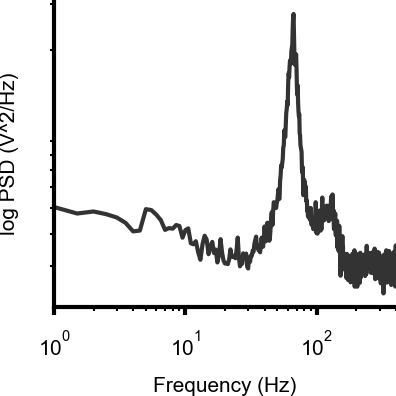

In [9]:
idx_xo = 10030 #24072 
xo_raw = df_xos.loc[idx_xo][cols_features].values
plt.loglog(freqs, xo_raw, "k", alpha=0.8)
plt.xlabel("Frequency (Hz)")
plt.ylabel("log PSD (V^2/Hz)")
plt.yticks([])
plt.xlim([1, 400])
plt.tight_layout()

In [10]:
df_xos_preproc, _, _, _ = dist_utils.preproc_dataframe_psd(
    df_xos.loc[[idx_xo]],
    posterior.x_bounds_and_transforms,
    drop_nans=False,
    replace_infs=True,
)
xo = df_xos_preproc.loc[idx_xo][cols_features].values
xo_tensor = posterior.x_standardizing_func(Tensor(xo[None, :]))
print(f"Target observation has shape {xo_tensor.shape}")

0 sims dropped due to early stopping.
0 sims dropped due to manual criteria.
0 sims dropped due to power threshold discard.
0 samples discarded in total.
Target observation has shape torch.Size([1, 990])


In [11]:
params_dict['params_settings']['sim_time'] = 20.1 * b2.second

In [12]:
# Set batch and random seeds
batch_seed = 20240823
data_utils.set_all_seeds(batch_seed)

n_samples = 5
cfg_sample = {
    "name": "demo_NPE",
    "oversample_factor": 200,
    "do_sample_map": False,
    "do_sample_pmean": False,
}

df_samples, samples_dict = inferer.sample_from_posterior(
    posterior=posterior,  # Posterior network
    prior=posterior,  # Need for extracting bounds
    num_samples=n_samples,  # Number of samples to draw
    x_o=xo_tensor,  # Target observation
    cfg_algorithm=cfg_sample,  # Sampling options
)

df_samples

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

WARNING    c:\Users\Brian Leung\anaconda3\envs\automind\Lib\site-packages\nflows\transforms\lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\BatchLinearAlgebra.cpp:2196.)
  outputs, _ = torch.triangular_solve(
 [py.warnings]
WARNING    c:\users\brian leung\automind\automind\inference\inferer.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the

,inference.type,infer.log_prob,params_net.exc_prop,params_net.p_e2e,params_net.p_e2i,params_net.p_i2e,params_net.p_i2i,params_net.R_pe2e,params_net.R_Qe2e,params_Epop.p_igniters,...,params_Epop.tau_w,params_Epop.E_gi,params_Epop.Q_ge,params_Epop.Q_gi,params_Epop.tau_ge,params_Epop.tau_gi,params_Epop.poisson_rate,params_Ipop.Q_ge,params_Ipop.Q_gi,params_Ipop.poisson_rate
0,demo_NPE_samples_prune_200,15.478234,0.781976,0.024205,0.046846,0.136436,0.163399,1.741673,1.363146,0.985057,...,11443.256836,-75.929283,3.060467,19.517963,15.427567,9.961976,4.555907,4.664643,9.066059,2.592391
1,demo_NPE_samples_prune_200,15.065972,0.887588,0.015302,0.068126,0.188009,0.159533,2.209650,1.148185,0.840746,...,14098.856445,-71.622284,3.000145,15.371986,16.391203,5.304994,4.893124,3.806506,18.270649,2.659153
2,demo_NPE_samples_prune_200,15.014527,0.822215,0.014814,0.047441,0.190952,0.138233,1.349009,1.857210,0.975408,...,6209.625488,-66.171959,2.846389,12.226162,13.769766,6.223670,4.216797,4.358891,19.230453,3.134104
3,demo_NPE_samples_prune_200,14.686700,0.839105,0.027946,0.044362,0.170837,0.160690,1.274470,1.924716,0.988818,...,13207.694336,-69.557861,1.817512,19.466223,16.811691,12.037836,4.515242,2.796455,11.720339,2.666298
4,demo_NPE_samples_prune_200,14.614984,0.889516,0.088333,0.055020,0.193097,0.173899,1.099473,1.821712,0.970462,...,7233.524902,-80.781227,1.527140,10.012545,15.281599,16.944878,4.904883,4.514219,9.945759,2.208321


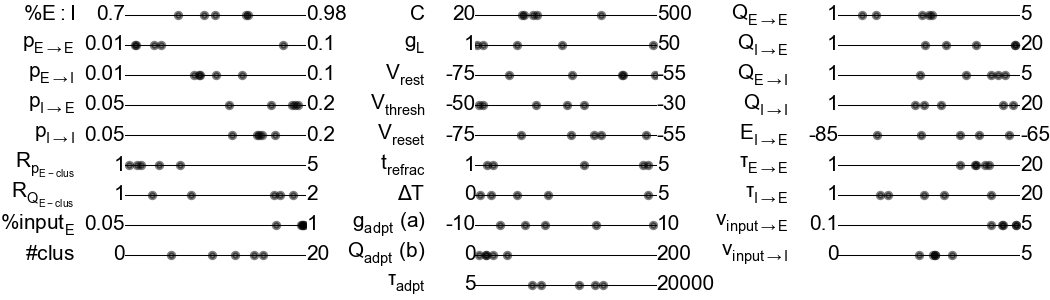

In [13]:
from automind.sim.default_configs import MKI_pretty_param_names

_, theta_minmax = dist_utils.standardize_theta(posterior.prior.sample((1,)), posterior)
fig, axs = plt.subplots(10, 3, figsize=(3.5, 1))
plot_utils.plot_params_1D(
    df_samples[posterior.names].values,
    theta_minmax,
    MKI_pretty_param_names,
    (fig, axs),
    color="k",
    draw_canvas=True,
    draw_kde=False,
    draw_samples=True,
    labelpad=12,
    draw_median=False,
    sample_ms=3,
    sample_alpha=0.5,
);

In [14]:
# Some housekeeping to set random seed identifiers and set up simulation configurations
# params_dict['params_settings']['batch_seed'] = batch_seed
random_seeds = np.sort(
    np.random.choice(a=int(n_samples * 100), size=n_samples, replace=False)
)
df_samples.insert(loc=0, column="params_settings.batch_seed", value=batch_seed)
df_samples.insert(loc=1, column="params_settings.random_seed", value=random_seeds)

# NOTE: This sets the correct early-stopping condition, i.e., to assess the simulation from 0.1 to 10.1 seconds.
params_dict['params_analysis']['analysis_window'] = [0.1, None] 

params_dict_run = data_utils.fill_params_dict(
    params_dict, df_samples, posterior.as_dict, n_samples
)

params_settings.batch_seed has no prior. Copied as bare value without unit.
params_settings.random_seed has no prior. Copied as bare value without unit.


# Selecting specific networks

In [313]:
df_xos[df_xos['inference.type']=='gt_resim']

,params_settings.batch_seed,params_settings.random_seed,x_o,inference.type,infer.log_prob,params_net.exc_prop,params_net.p_e2e,params_net.p_e2i,params_net.p_i2e,params_net.p_i2i,...,psd_495.5,psd_496.0,psd_496.5,psd_497.0,psd_497.5,psd_498.0,psd_498.5,psd_499.0,psd_499.5,psd_500.0
0,7149324,4,3285553_18970,gt_resim,7.528021,0.955352,0.098917,0.051536,0.112586,0.195101,...,0.001625,0.001670,0.001661,0.001782,0.002010,0.001769,0.001663,0.001607,0.001566,0.000902
1003,7149324,101263,3285553_19034,gt_resim,9.160380,0.711092,0.016933,0.036978,0.166615,0.112324,...,0.188490,0.192429,0.172469,0.147972,0.157238,0.162760,0.167964,0.157029,0.138801,0.065551
2006,7149324,202896,3285553_27770,gt_resim,-3.564012,0.750114,0.029067,0.032747,0.119021,0.120282,...,0.020013,0.019780,0.018718,0.017571,0.016351,0.015352,0.015270,0.015616,0.017154,0.008754
3009,7149324,306041,3285553_39711,gt_resim,7.749297,0.879665,0.013448,0.012098,0.165279,0.177838,...,0.412450,0.454684,0.473000,0.438638,0.433563,0.380528,0.417967,0.421964,0.439464,0.216283
4012,7149324,404613,3285553_68555,gt_resim,3.990584,0.787252,0.075443,0.073838,0.061622,0.067039,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5015,7149324,516680,3285553_95008,gt_resim,7.578330,0.820451,0.028541,0.049560,0.068745,0.120469,...,0.014674,0.013861,0.013120,0.014117,0.014154,0.012031,0.013434,0.014061,0.016114,0.007999
6018,7149324,609117,3285553_138601,gt_resim,11.050361,0.933421,0.024859,0.031092,0.105735,0.144186,...,0.012290,0.011586,0.010372,0.011719,0.011655,0.011068,0.012604,0.012268,0.011872,0.005739
7021,7149324,708405,3285553_152746,gt_resim,1.371520,0.872355,0.043042,0.073531,0.097607,0.142163,...,0.034458,0.032945,0.031893,0.031873,0.036294,0.034351,0.032212,0.032035,0.031447,0.016129
8024,7149324,810232,3285553_202374,gt_resim,7.959204,0.976444,0.069510,0.085779,0.152359,0.146778,...,0.002597,0.002592,0.002472,0.002416,0.002324,0.002396,0.002546,0.002661,0.002327,0.001123
9027,7149324,911963,3285553_208302,gt_resim,8.458587,0.726262,0.074080,0.059844,0.147120,0.195604,...,0.574660,0.641692,0.722048,0.898921,1.190606,1.676179,2.609961,4.628331,28.337404,39.974145


In [ ]:
#10030 - gamma
#24072 - metatstable

In [346]:
#Run this instead of the cells above if you manually selected the samples instead of resampling 
xo = df_xos.iloc[10030][cols_features].values #24072 is resim for assemblies 
samples = df_xos.iloc[10030:][cols_features].values
log_samples = True
stdz_func = posterior.x_standardizing_func
#standardised_xo = dist_utils.log_n_stdz([xo],stdz_func)
standardised_samples = dist_utils.log_n_stdz(samples,stdz_func)
include_mapnmean = True
sort_samples=True
sort_weights=((freqs>=50) & (freqs<=400)) #Filter unwanted frequencies 
# df_collect, samples_x_collect, samples_theta_collect = data_utils.collect_all_xo_and_posterior_preds(df_xos, df_posterior_sims, xo_queries, cols_features, cols_params, log_samples, stdz_func, include_mapnmean, sort_samples, sort_weights)

samples_sorted, dists, idx_sorted = dist_utils.sort_closest_to_xo(
                    standardised_samples[0,:], standardised_samples, "mse",top_n=None, weights=sort_weights
                )

params_dict['params_settings']['sim_time'] = 20.1 * b2.second #Changing simulation time to 20 seconds for quick checking 
n_samples = 5
df_samples = df_xos.iloc[10030+idx_sorted[1:6]] #Top 5 samples closest to the "true" oscillation
df_samples = df_samples.iloc[:,3:33] #Only network information (or else unwanted info will be passed to fill_params_dict)

WARNING    c:\users\brian leung\automind\automind\utils\dist_utils.py:428: RuntimeWarning: divide by zero encountered in log10
  samples = np.log10(samples)
 [py.warnings]
WARNING    c:\users\brian leung\automind\automind\utils\dist_utils.py:463: RuntimeWarning: invalid value encountered in multiply
  dist = (dists * weights).mean(1)
 [py.warnings]


WARNING    C:\Users\Brian Leung\AppData\Local\Temp\ipykernel_28456\3834733477.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
 [py.warnings]


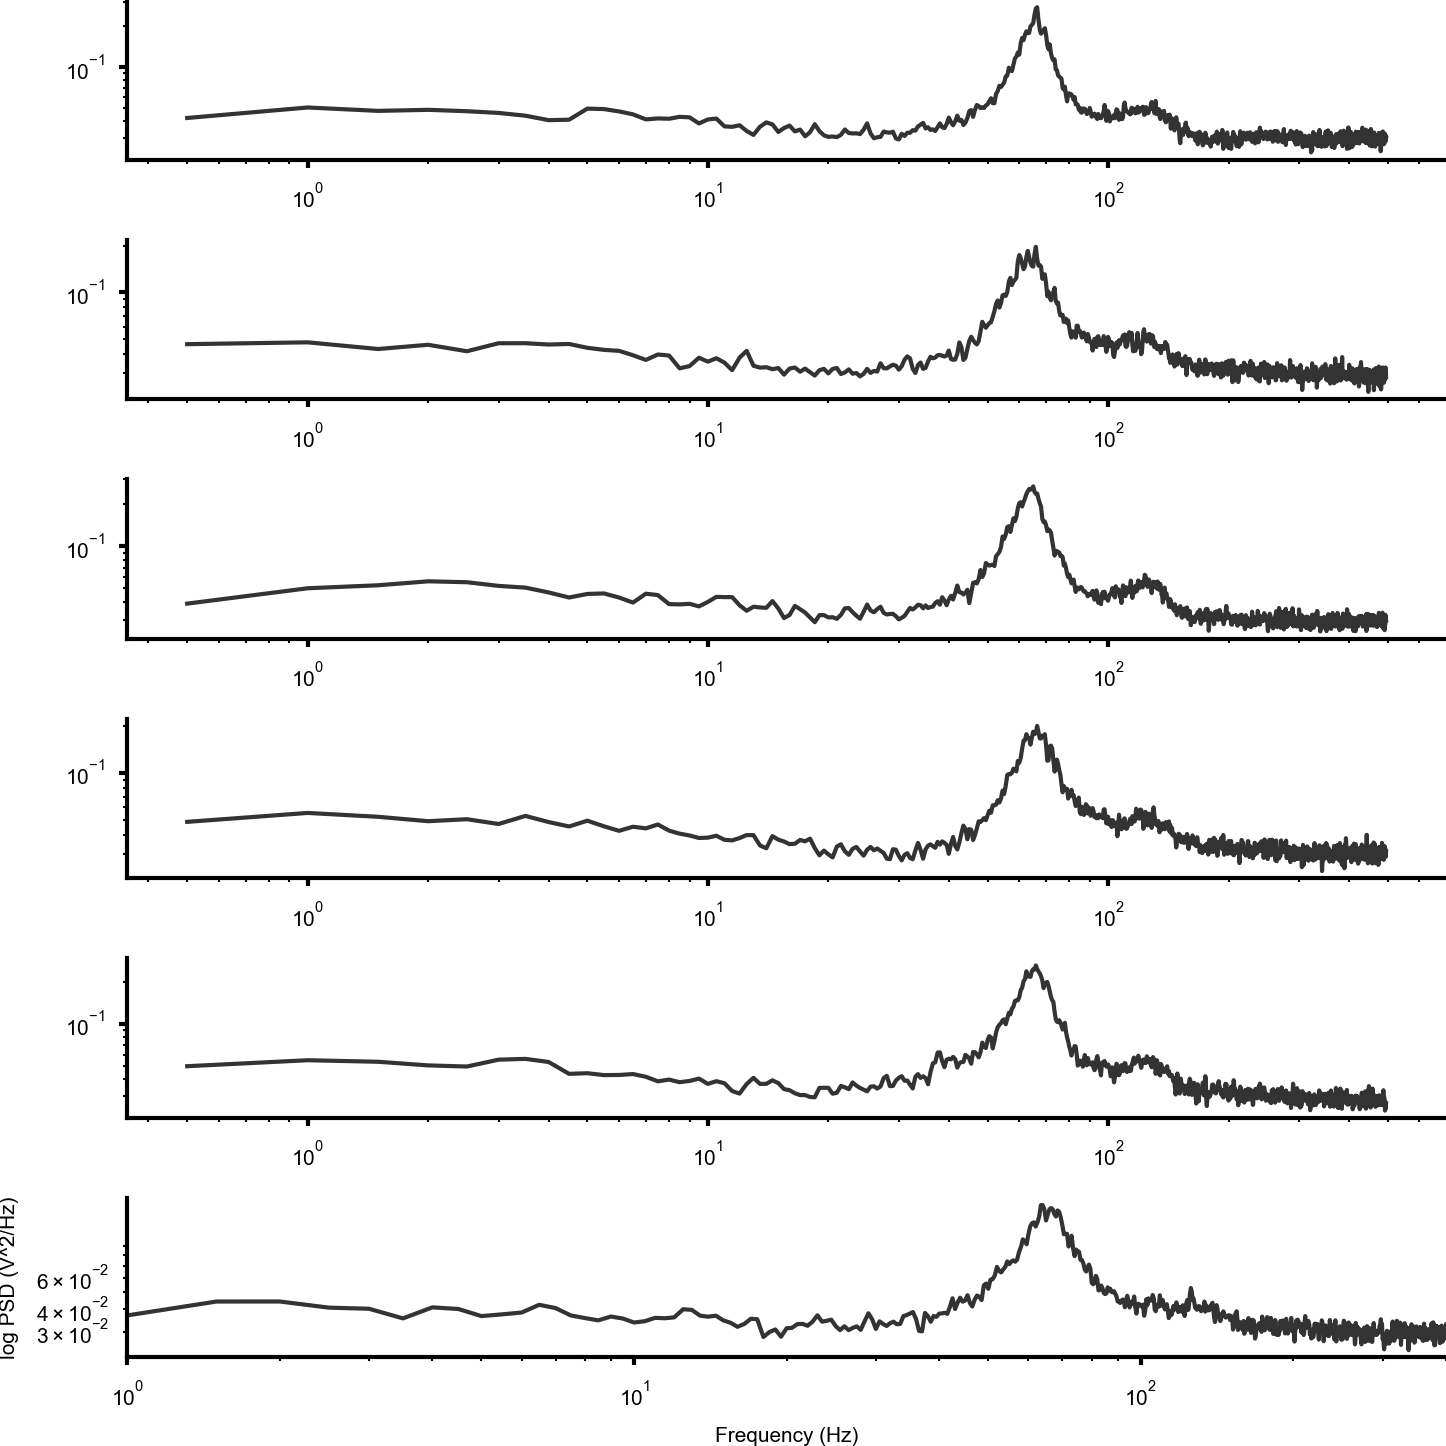

In [337]:
fig, ax = plt.subplots(6,figsize=(5,5))
for i in range(6):
    idx_xo = 10030 + idx_sorted[i]
    xo_raw = df_xos.loc[idx_xo][cols_features].values
    ax[i].loglog(freqs, xo_raw, "k", alpha=0.8)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("log PSD (V^2/Hz)")
    plt.yticks([])
    plt.xlim([1, 400])
    plt.tight_layout()

In [347]:

# NOTE: This sets the correct early-stopping condition, i.e., to assess the simulation from 0.1 to 10.1 seconds.
params_dict['params_analysis']['analysis_window'] = [0.1, None] 
params_dict_run = data_utils.fill_params_dict(
    params_dict, df_samples, posterior.as_dict, n_samples
)

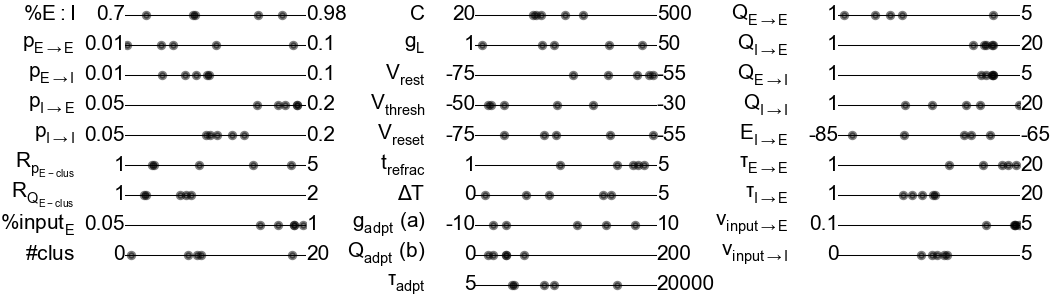

In [348]:
from automind.sim.default_configs import MKI_pretty_param_names

_, theta_minmax = dist_utils.standardize_theta(posterior.prior.sample((1,)), posterior)
fig, axs = plt.subplots(10, 3, figsize=(3.5, 1))
plot_utils.plot_params_1D(
    df_samples[posterior.names].values,
    theta_minmax,
    MKI_pretty_param_names,
    (fig, axs),
    color="k",
    draw_canvas=True,
    draw_kde=False,
    draw_samples=True,
    labelpad=12,
    draw_median=False,
    sample_ms=3,
    sample_alpha=0.5,
);

# Extending the input

- Keep the poisson input
- Make another function for constructing the stimulus
- Decoding

Function properties:
- input signal
- scaled input signal to n = n_neurons in network (0s or 1s, or random between 0 and 1)


In [16]:
#old function 


def adaptive_exp_net_clustered(all_param_dict):
    """Adaptive exponential integrate-and-fire network with clustered connections."""
    # separate parameter dictionaries
    param_dict_net = all_param_dict["params_net"]
    param_dict_settings = all_param_dict["params_settings"]

    # set random seeds
    b2.seed(param_dict_settings["random_seed"])
    np.random.seed(param_dict_settings["random_seed"])
    b2.defaultclock.dt = param_dict_settings["dt"]

    param_dict_neuron_E = all_param_dict["params_Epop"]
    # check if there is inhibition
    has_inh = False if param_dict_net["exc_prop"] == 1 else True
    if has_inh:
        param_dict_neuron_I = all_param_dict["params_Ipop"]

    #### NETWORK CONSTRUCTION ############
    ######################################
    ### define neuron equation
    adex_coba_eq = """dv/dt = (-g_L * (v - v_rest) + g_L * delta_T * exp((v - v_thresh)/delta_T) - w + I)/C : volt (unless refractory)"""
    adlif_coba_eq = (
        """dv/dt = (-g_L * (v - v_rest) - w + I)/C : volt (unless refractory)"""
    )

    network_eqs = """            
            dw/dt = (-w + a * (v - v_rest))/tau_w : amp
            dge/dt = -ge / tau_ge : siemens
            dgi/dt = -gi / tau_gi : siemens
            Ie = ge * (E_ge - v): amp
            Ii = gi * (E_gi - v): amp
            I = I_bias + Ie + Ii : amp
            """

    ### get cell counts
    N_pop, exc_prop = param_dict_net["N_pop"], param_dict_net["exc_prop"]
    N_exc, N_inh = int(N_pop * exc_prop), int(N_pop * (1 - exc_prop))

    ### make neuron populations, set initial values and connect poisson inputs ###
    # make adlif if delta_t is 0, otherwise adex
    neuron_eq = (
        adlif_coba_eq + network_eqs
        if param_dict_neuron_E["delta_T"] == 0
        else adex_coba_eq + network_eqs
    )
    E_pop = b2.NeuronGroup(
        N_exc,
        model=neuron_eq,
        threshold="v > v_cut",
        reset="v = v_reset; w+=b",
        refractory=param_dict_neuron_E["t_refrac"],
        method=param_dict_settings["integ_method"],
        namespace=param_dict_neuron_E,
        name="Epop",
    )
    E_pop.v = (
        param_dict_neuron_E["v_rest"]
        + np.random.randn(N_exc) * param_dict_neuron_E["v_0_offset"][1]
        + param_dict_neuron_E["v_0_offset"][0]
    )

    ### SUBSET INPUT
    # define subset of E cells that receive input, to model
    # spontaneously active cells (which are a small proportion)
    N_igniters = int(param_dict_neuron_E["p_igniters"] * N_exc)
    # has to be a contiguous chunk
    E_igniters = E_pop[:N_igniters]

    # connect poisson input only to igniter neurons
    poisson_input_E = b2.PoissonInput(
        target=E_igniters,
        target_var="ge",
        N=param_dict_neuron_E["N_poisson"],
        rate=param_dict_neuron_E["poisson_rate"],
        weight=param_dict_neuron_E["Q_poisson"],
    )
    
    #### resolve inhibitory population
    if has_inh:
        # make adlif if delta_t is 0, otherwise adex
        neuron_eq = (
            adlif_coba_eq + network_eqs
            if param_dict_neuron_E["delta_T"] == 0
            else adex_coba_eq + network_eqs
        )
        I_pop = b2.NeuronGroup(
            N_inh,
            model=neuron_eq,
            threshold="v > v_cut",
            reset="v = v_reset; w+=b",
            refractory=param_dict_neuron_I["t_refrac"],
            method=param_dict_settings["integ_method"],
            namespace=param_dict_neuron_I,
            name="Ipop",
        )
        I_pop.v = (
            param_dict_neuron_I["v_rest"]
            + np.random.randn(N_inh) * param_dict_neuron_I["v_0_offset"][1]
            + param_dict_neuron_I["v_0_offset"][0]
        )
        # check for poisson input
        if (param_dict_neuron_I["N_poisson"] == 0) or (
            param_dict_neuron_I["poisson_rate"] == 0
        ):
            poisson_input_I = []
        else:
            poisson_input_I = b2.PoissonInput(
                target=I_pop,
                target_var="ge",
                N=param_dict_neuron_I["N_poisson"],
                rate=param_dict_neuron_I["poisson_rate"],
                weight=param_dict_neuron_I["Q_poisson"],
            )

    ############## SYNAPSES ####################
    ### make and connect recurrent synapses ###
    if (
        ("n_clusters" not in param_dict_net.keys())
        or (param_dict_net["n_clusters"] < 2)
        or (param_dict_net["R_pe2e"] == 1)
    ):
        # make homogeneous connection if 0,1 (or unspecified) cluster, or R_pe2e (ratio between in:out connection prob) is 1
        # print('homogeneous')
        syn_e2e = b2.Synapses(
            source=E_pop,
            target=E_pop,
            model="q: siemens",
            on_pre="ge_post += Q_ge",
            delay=param_dict_neuron_E["tdelay2e"],
            namespace=param_dict_neuron_E,
            name="syn_e2e",
        )
        syn_e2e.connect("i!=j", p=param_dict_net["p_e2e"])

    else:
        # print(f'clustered: n_clusters={param_dict_net["n_clusters"]}')
        # scale connectivity probability and make clustered connections
        p_out = param_dict_net["p_e2e"]
        p_in = p_out * param_dict_net["R_pe2e"]

        # NOTE: if cluster membership is ordered (last arg), then it explicitly makes
        # block diagonal wrt neuron id, which coincides with input (first n)
        # otherwise, clusters id are randomly assigned
        # print('ordered cluster id' if param_dict_net['order_clusters'] else 'random cluster id')
        #
        # Also, given non-integer n_clusters, int() is applied, which floors it.
        membership, shared_membership, conn_in, conn_out = b2_models.make_clustered_network(
            N_exc,
            param_dict_net["n_clusters"],
            param_dict_net["clusters_per_neuron"],
            p_in,
            p_out,
            param_dict_net["order_clusters"],
        )

        # scale synaptic weight
        Q_ge_out = param_dict_neuron_E["Q_ge"]
        param_dict_neuron_E["Q_ge_out"] = Q_ge_out
        param_dict_neuron_E["Q_ge_in"] = Q_ge_out * param_dict_net["R_Qe2e"]

        # make synapses and connect
        # in-cluster synapses
        syn_e2e_in = b2.Synapses(
            source=E_pop,
            target=E_pop,
            model="q: siemens",
            on_pre="ge_post += Q_ge_in",
            delay=param_dict_neuron_E["tdelay2e"],
            namespace=param_dict_neuron_E,
            name="syn_e2e_in",
        )
        syn_e2e_in.connect(i=conn_in[0, :], j=conn_in[1, :])

        # across-cluster synapses
        syn_e2e_out = b2.Synapses(
            source=E_pop,
            target=E_pop,
            model="q: siemens",
            on_pre="ge_post += Q_ge_out",
            delay=param_dict_neuron_E["tdelay2e"],
            namespace=param_dict_neuron_E,
            name="syn_e2e_out",
        )
        syn_e2e_out.connect(i=conn_out[0, :], j=conn_out[1, :])

    if has_inh:
        # no clustered connections to or from inhibitory populations
        # e to i
        syn_e2i = b2.Synapses(
            source=E_pop,
            target=I_pop,
            model="q: siemens",
            on_pre="ge_post += Q_ge",
            delay=param_dict_neuron_E["tdelay2i"],
            namespace=param_dict_neuron_I,
            name="syn_e2i",
        )
        syn_e2i.connect("i!=j", p=param_dict_net["p_e2i"])

        # i to e
        syn_i2e = b2.Synapses(
            source=I_pop,
            target=E_pop,
            model="q: siemens",
            on_pre="gi_post += Q_gi",
            delay=param_dict_neuron_I["tdelay2e"],
            namespace=param_dict_neuron_E,
            name="syn_i2e",
        )
        syn_i2e.connect("i!=j", p=param_dict_net["p_i2e"])

        # i to i
        syn_i2i = b2.Synapses(
            source=I_pop,
            target=I_pop,
            model="q: siemens",
            on_pre="gi_post += Q_gi",
            delay=param_dict_neuron_I["tdelay2i"],
            namespace=param_dict_neuron_I,
            name="syn_i2i",
        )
        syn_i2i.connect("i!=j", p=param_dict_net["p_i2i"])

    ### define monitors ###
    rate_monitors, spike_monitors, trace_monitors = [], [], []
    rec_defs = param_dict_settings["record_defs"]
    dt_ts = param_dict_settings["dt_ts"]  # recording interval for continuous variables
    zipped_pops = (
        zip(["exc", "inh"], [E_pop, I_pop]) if has_inh else zip(["exc"], [E_pop])
    )
    for pop_name, pop in zipped_pops:
        if pop_name in rec_defs.keys():
            if rec_defs[pop_name]["rate"] is not False:
                rate_monitors.append(
                    b2.PopulationRateMonitor(pop, name=pop_name + "_rate")
                )
            if rec_defs[pop_name]["spikes"] is not False:
                if pop_name == "exc":
                    # special override for excitatory to record all first
                    # and later drop randomly before saving, otherwise
                    # recording only from first n neurons, which heavily overlap
                    # with those stimulated, and the first few clusters
                    rec_idx = np.arange(N_exc)
                else:
                    rec_idx = (
                        np.arange(rec_defs[pop_name]["spikes"])
                        if type(rec_defs[pop_name]["spikes"]) is int
                        else rec_defs[pop_name]["spikes"]
                    )
                spike_monitors.append(
                    b2.SpikeMonitor(pop[rec_idx], name=pop_name + "_spikes")
                )

            if rec_defs[pop_name]["trace"] is not False:
                rec_idx = (
                    np.arange(rec_defs[pop_name]["trace"][1])
                    if type(rec_defs[pop_name]["trace"][1]) is int
                    else rec_defs[pop_name]["trace"][1]
                )
                trace_monitors.append(
                    b2.StateMonitor(
                        pop,
                        rec_defs[pop_name]["trace"][0],
                        record=rec_idx,
                        name=pop_name + "_trace",
                        dt=dt_ts,
                    )
                )

    ### collect into network object and return ###
    net_collect = b2.Network(b2.collect())  # magic collect all groups
    monitors = [rate_monitors, spike_monitors, trace_monitors]
    net_collect.add(monitors)
    return net_collect

In [42]:
#test first with a signal increasing by 1 per step to see where the signal stabilises 
def cog_tasks(all_param_dict,scaling):
    #Separate parameter dictionaries
    param_dict_net = all_param_dict["params_net"]
    param_dict_settings = all_param_dict["params_settings"]

    #Set random seeds
    b2.seed(param_dict_settings["random_seed"])
    np.random.seed(param_dict_settings["random_seed"])
    b2.defaultclock.dt = param_dict_settings["dt"]

    #Setting stimulation and simulation length 
    stim_steps = int(1 * b2.second / b2.defaultclock.dt) #Potentially change stim length to user added input 
    total_steps = int(0.1*param_dict_settings['sim_time']/b2.defaultclock.dt)
    if stim_steps > total_steps:
        raise ValueError("Stimulus steps exceed total simulation steps.")
    
    #Stimulation signal with step increasing signals 
    random_signal = np.random.rand(stim_steps)
    stim = np.zeros(total_steps)
    #stim[0:stim_steps] = random_signal
    for i in range(10):
        stim[10*i:10*(i+1)] += i
    input_signal = TimedArray(stim*b2.amp, dt = b2.defaultclock.dt)
    
    #Scaling input for different neurons 
    n_neurons = param_dict_net['N_pop']
    if scaling == 'all':
        input_scaling = np.ones(n_neurons).astype(int)
    elif scaling == 'rand':
        input_scaling = np.random.rand(n_neurons)
    elif scaling == 'subset':
        input_scaling = np.random.randint(0,2,n_neurons)
    else:
        raise ValueError(f"Invalid input for 'scaling': {scaling}. Choose from 'all', 'rand', or 'subset'.")

    
    return input_signal, input_scaling
    '''
    #Create a single noisy input signal between 0 and 1 
    stim_steps = int(1 * b2.second / b2.defaultclock.dt)
    total_steps = int(param_dict_settings['sim_time']/b2.defaultclock.dt)
    random_signal = np.random.rand(stim_steps)
    stim = np.zeros(total_steps)
    stim[0:stim_steps] = random_signal
    DM_input = b2.TimedArray(stim*b2.amp, dt = b2.defaultclock.dt)
    '''


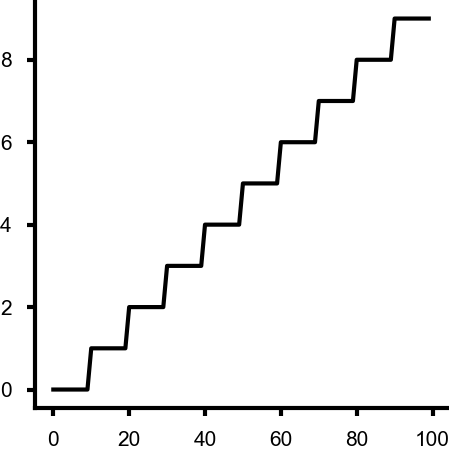

In [17]:
test = int(1 * b2.second / b2.defaultclock.dt)
np.random.rand(test)
test2 = int(params_dict['params_settings']['sim_time']/b2.defaultclock.dt)
stim = np.zeros(test2)
#stim[0:test] += 0.1*np.random.rand(test)
for i in range(10):
    stim[10*i:10*(i+1)] += i
plt.plot(stim[0:100])
#input_signal = TimedArray(stim * b2.amp, dt = params_dict['params_settings']["dt"])

In [11]:
N_exc_test = int(params_dict['params_net']['N_pop'] * params_dict['params_net']['exc_prop'])
N_exc_test
test_arr = np.zeros(params_dict['params_net']['N_pop'])
a = test_arr[:N_exc_test]
b = test_arr[N_exc_test:]
both = np.concatenate([a,b])
print(np.shape(test_arr))
print(np.shape(both))

(2000,)
(2000,)


In [18]:
#run and collect data 
def run_net_early_stop(net_collect, params_dict):
    """
    Run simulation while checking for early stoppage.
    """
    # ---- early stoppage ----
    start_time = time()
    if params_dict["params_analysis"]["t_early_stop"]:
        # run for short time and check for min/max firing
        net_collect.run(params_dict["params_analysis"]["t_early_stop"])
        params_dict = adex_check_early_stop(net_collect, params_dict, verbose=False)
        # did not stop, continue with sim the rest of the way
        if not params_dict["params_analysis"]["early_stopped"]:
            net_collect.run(
                params_dict["params_settings"]["sim_time"]
                - params_dict["params_analysis"]["t_early_stop"]
            )
def collect_raw_data(net_collect, params_dict):
    """Collect all raw data from the network collector."""
    # get spikes
    spikes = collect_spikes(net_collect, params_dict)
    timeseries = collect_timeseries(net_collect, params_dict)

    all_pop_sampler = {pop.split("_")[0]: None for pop in spikes.keys()}
    # compute rates
    rates = spikes_summary.compute_poprate_from_spikes(
        spikes,
        t_collect=(0, net_collect.t / second),
        dt=params_dict["params_settings"]["dt_ts"] / second,
        dt_bin=params_dict["params_settings"]["dt"] / second,
        pop_sampler=all_pop_sampler,
        smooth_std=params_dict["params_analysis"]["smooth_std"],
    )
    timeseries = {**timeseries, **rates}
    return spikes, timeseries

Input–Output Transformations

q: Not training network, just seeing how the invariant ones respond to it right? 

## **DM (Decision Making Task)**

- **Stimulus Phase**:  
  One input (\(x_1\) or \(x_2\)) is selected from a noisy signal with a mean chosen between 0 and 1.  
  - **Target Output**: \(0\).

- **Response Phase**:  
  The inputs are zero.  
  - **Target Output**:  
    - \(1\) if the time average of \(x_1\) (or \(x_2\)) is below the threshold \(T\).  
    - \(0\) otherwise.  

  *(Refer to Fig. 2a, g)*

---

## **CtxDM (Context Decision-Making Task)**

- **Stimulus Phase**:  
  Two inputs (\(x_1\) and \(x_2\)) are selected from two noisy signals with specific means.  
  The context input \(C\) specifies which of the two values should be compared with the threshold \(T\), while the other is ignored.  

- **Response Phase**:  
  The inputs are zero.  
  - **Target Output**:  
    - \(1\) if the time average of the relevant input is below the threshold \(T\).  
    - \(0\) otherwise.  

  *(Refer to Fig. 2b, h)*

---

## **Romo (Working Memory Romo Task)**

- **Stimulus Phase**:  
  One input (\(x_1\) or \(x_2\)) is selected from two consecutive rectangular pulses separated by a time delay.  

- **Response Phase**:  
  - **Target Output**:  
    - \(1\) if the first stimulus is larger than the second.  
    - \(0\) otherwise.  

  *(Refer to Fig. 2f, l)*

---

## **Go (Go/No-Go Task)**

- **Trial Phase**:  
  One input (\(x_1\) or \(x_2\)) is selected from a noisy signal with a mean between 0 and 1.  

- **Response Phase**:  
  - **Target Output**:  
    - The corresponding output (\(y_1\) or \(y_2\)) generates a constant signal equal to the input mean.  

  *(Refer to Fig. 2c, i)*

---

## **GoRt (Reaction Time Go Task)**

- **Trial Phase**:  
  The fixation input equals 1, and all other inputs are initially zero.  
  At a random moment during the trial, one noisy input (\(x_1\) or \(x_2\)) is switched on with a specific mean.  

- **Response Phase**:  
  - **Target Output**:  
    - The corresponding output (\(y_1\) or \(y_2\)) generates a signal of the same magnitude as the input.  

  *(Refer to Fig. 2d, j)*

---

## **GoDl (Delayed Version of the Go Task)**

- **Stimulus Phase**:  
  One input (\(x_1\) or \(x_2\)) produces a short rectangular pulse with a magnitude between 0 and 1.  

- **Response Phase**:  
  - **Target Output**:  
    - The corresponding output (\(y_1\) or \(y_2\)) generates a signal of the same magnitude when the fixation input vanishes.  

  *(Refer to Fig. 2e, k)*

---


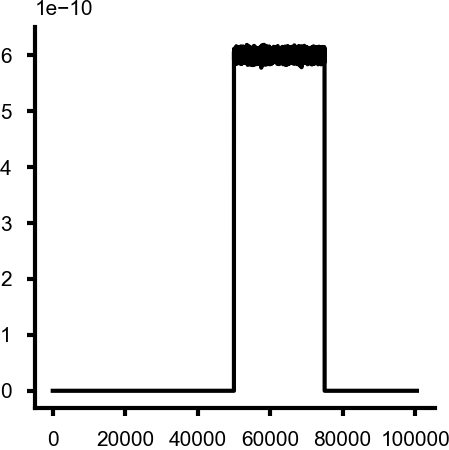

In [14]:
a,b = b2_models.DM(params_dict)
plt.plot(b)

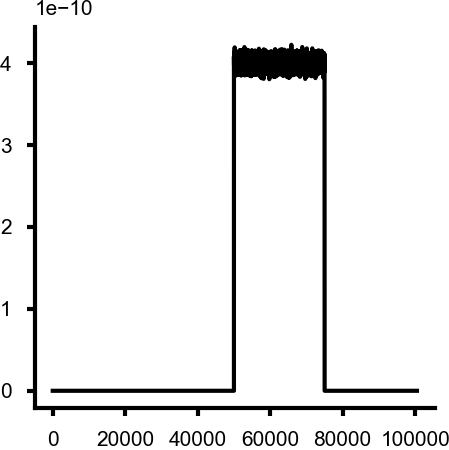

In [24]:
a,b = b2_models.cog_tasks(params_dict,"DM","all")
plt.plot(a[0])


In [28]:
b[0,1600:1700]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [19]:
#wrapper 
def adex_simulator(params_dict):
    """
    Simulator wrapper for AdEx net, run simulations and collect data.
    """

    print(
        f"{params_dict['params_settings']['batch_seed']}-{params_dict['params_settings']['random_seed']}",
        end="|",
    )

    try:
        # set up and run model with early stopping
        network_type = params_dict["params_settings"]["network_type"]
        if (not network_type) or (network_type == "adex"):
            net_collect = b2_models.adaptive_exp_net(params_dict)
        elif network_type == "adex_clustered":
            net_collect = b2_models.adaptive_exp_net_clustered_cog(params_dict,True)

        # run the model
        params_dict, net_collect = runners.run_net_early_stop(net_collect, params_dict)

        # return pickleable outputs for pool
        spikes, timeseries = data_utils.collect_raw_data(net_collect, params_dict)

        return params_dict, spikes, timeseries

    except Exception as e:
        print("-----")
        print(e)
        print(
            f"{params_dict['params_settings']['batch_seed']}-{params_dict['params_settings']['random_seed']}: FAILED"
        )
        print("-----")
        return params_dict, {}, {}


In [29]:
#Simulation 
cache_path = "./.cache/"
b2_interface.clear_b2_cache(cache_path)
b2_interface.set_b2_cache(cache_path, True)


sim_parallel = False
if sim_parallel:
    from multiprocessing import Pool

    start_time = time()
    with Pool(n_samples) as pool:
        sim_collector = pool.map(adex_simulator, params_dict_run)
    print(f"Simulations took {time()-start_time:.2f} seconds.")
else:
    sim_collector = []
    for i_sim in range(n_samples):
        start_time = time()
        sim_collector.append(adex_simulator(params_dict_run[i_sim]))
        print(f"Simulation {i_sim+1}/{n_samples} took {time()-start_time:.2f} seconds.")

b2_interface.clear_b2_cache(cache_path)

cache non-existent.
20240823-40|Simulation 1/5 took 34.60 seconds.
20240823-151|Simulation 2/5 took 29.68 seconds.
20240823-282|Simulation 3/5 took 29.38 seconds.
20240823-407|Simulation 4/5 took 30.66 seconds.
20240823-474|Simulation 5/5 took 30.67 seconds.
cache non-existent.


In [30]:
results_collector = [
    analysis_utils.compute_summary_features(sims[1], sims[0]) for sims in sim_collector
]

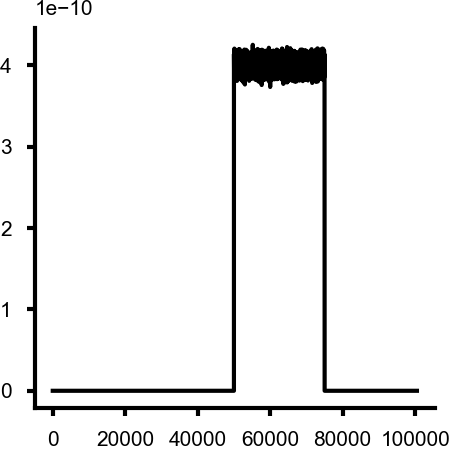

In [23]:
plt.plot(sim_collector[0][0]['params_Epop']['stim2'])

WARNING    c:\Users\Brian Leung\anaconda3\envs\automind\Lib\site-packages\IPython\core\events.py:82: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
 [py.warnings]
WARNING    c:\Users\Brian Leung\anaconda3\envs\automind\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)
 [py.warnings]


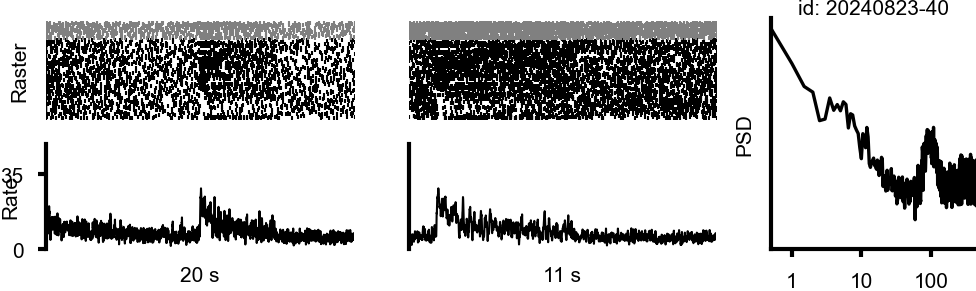

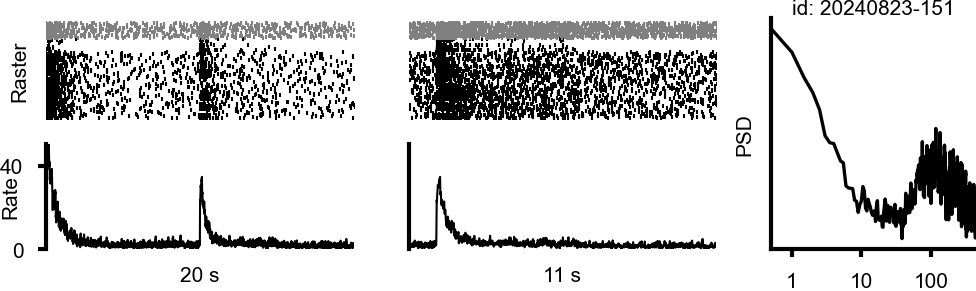

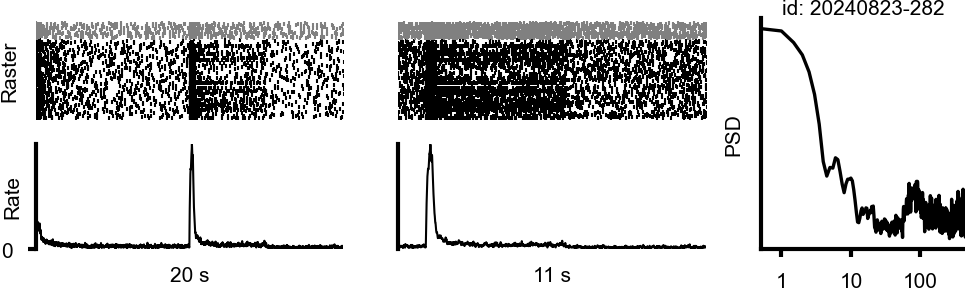

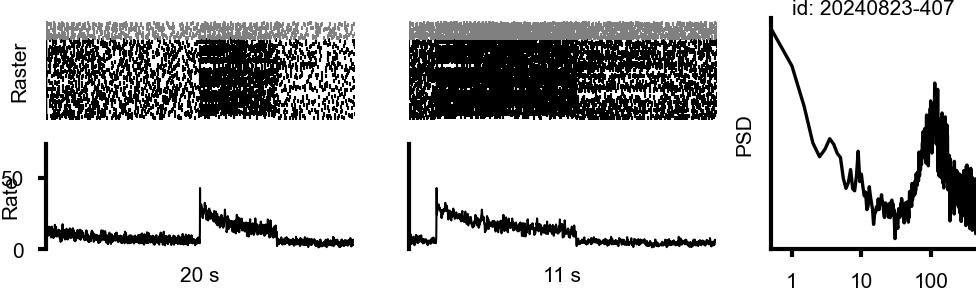

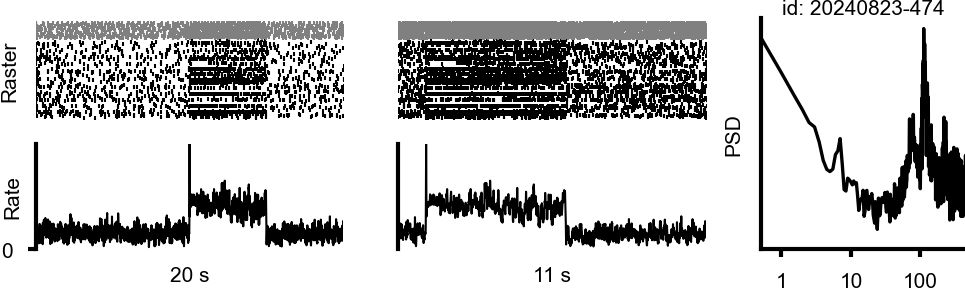

In [31]:
from matplotlib import gridspec

# Plot the results
xlims = [0, 20]
xlims_zoom = [9,20]
every_other = 10
for i_sim, results in enumerate(results_collector):
    fig = plt.figure(figsize=(4.0, 1.0))

    gs = gridspec.GridSpec(2, 3, width_ratios=[1.5, 1.5, 1], height_ratios=[1, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[0, 1])
    ax4 = fig.add_subplot(gs[1, 1])
    ax5 = fig.add_subplot(gs[:, 2])

    # Plot raster, rates, and PSD
    plot_utils._plot_raster_pretty(
        sim_collector[i_sim][1], XL=xlims, every_other=every_other, fontsize=5, ax=ax1
    )
    plot_utils._plot_rates_pretty(
        results_collector[i_sim]["pop_rates"],
        XL=xlims,
        pops_to_plot=["avgpop_rate"],
        ylim_past=10 * 1000,
        fontsize=5,
        ax=ax2,
        color="k",
    )
    ax2.set_ylabel("Rate", labelpad=-5)

    plot_utils._plot_raster_pretty(
        sim_collector[i_sim][1], XL=xlims_zoom, every_other=2, fontsize=5, ax=ax3
    )
    plot_utils._plot_rates_pretty(
        results_collector[i_sim]["pop_rates"],
        XL=xlims_zoom,
        pops_to_plot=["avgpop_rate"],
        ylim_past=10 * 1000,
        fontsize=5,
        ax=ax4,
        color="k",
    )
    plot_utils._plot_psd_pretty(
        results_collector[i_sim]["summary_psd"], ["avgpop_rate"], ax5, fontsize=5
    )
    max_rate = np.max(results_collector[i_sim]["pop_rates"]['avgpop_rate'])
    max_rate_half = np.max(results_collector[i_sim]["pop_rates"]['avgpop_rate'][0:len(results_collector[i_sim]["pop_rates"]['avgpop_rate'])])
    ax2.set_ylabel("Rate", labelpad=-5)
    ax2.set_ylim([0, max_rate])
    ax4.set_ylim([0, max_rate_half])
    ax3.set_ylabel("")
    ax4.set_ylabel("")
    ax4.set_yticks([])
    ax5.set_title(
        f"id: {batch_seed}-{sim_collector[i_sim][0]['params_settings']['random_seed']}",
        pad=0,
    )

WARNING    c:\Users\Brian Leung\anaconda3\envs\automind\Lib\site-packages\IPython\core\events.py:82: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
 [py.warnings]
WARNING    c:\Users\Brian Leung\anaconda3\envs\automind\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)
 [py.warnings]


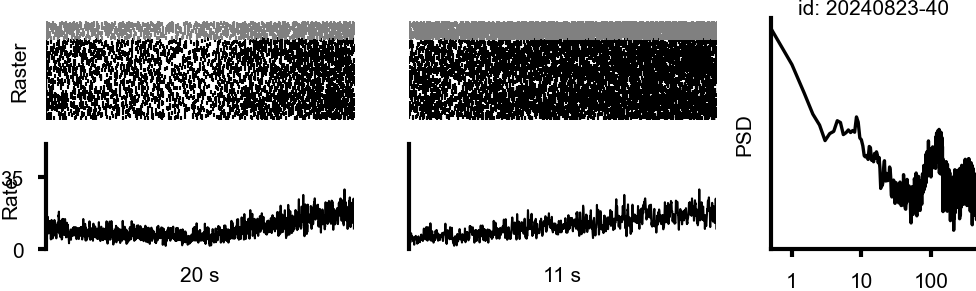

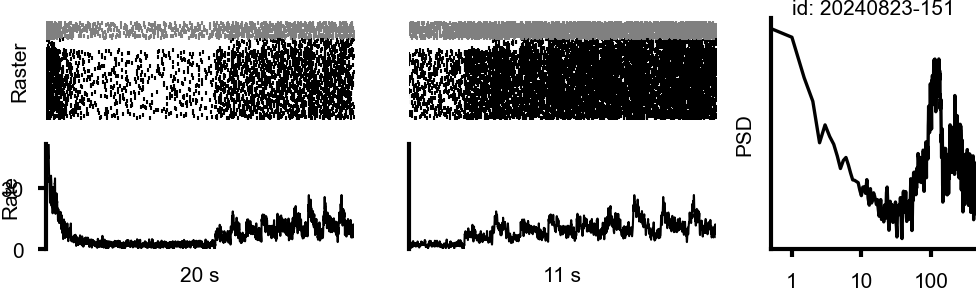

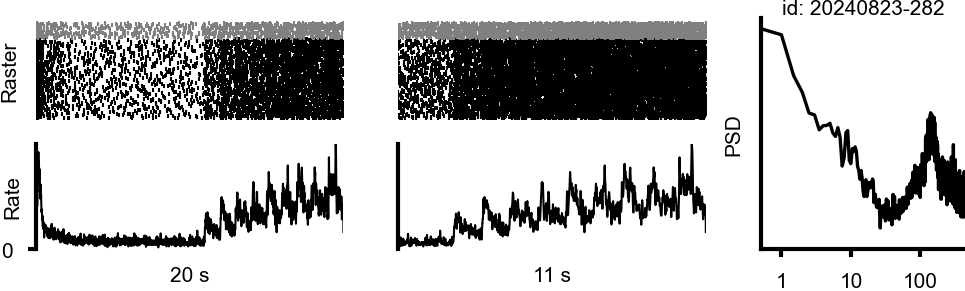

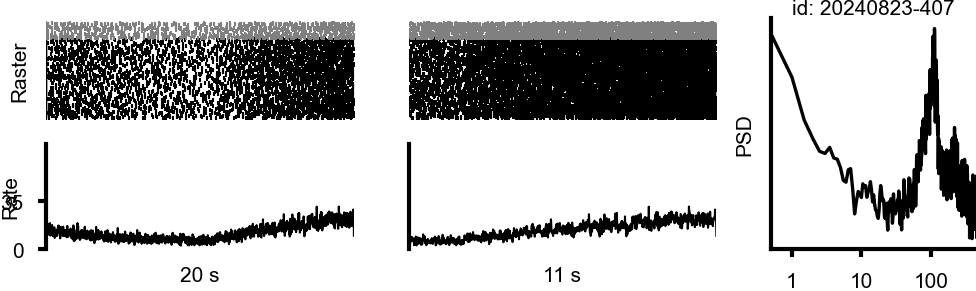

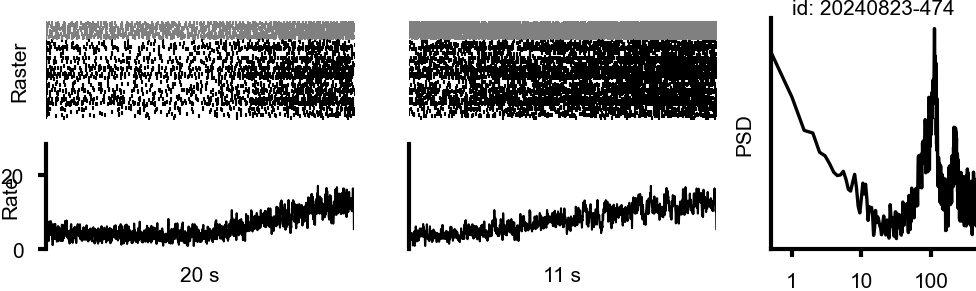

In [373]:
from matplotlib import gridspec

# Plot the results
xlims = [0, 20]
xlims_zoom = [9,20]
every_other = 10
for i_sim, results in enumerate(results_collector):
    fig = plt.figure(figsize=(4.0, 1.0))

    gs = gridspec.GridSpec(2, 3, width_ratios=[1.5, 1.5, 1], height_ratios=[1, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[0, 1])
    ax4 = fig.add_subplot(gs[1, 1])
    ax5 = fig.add_subplot(gs[:, 2])

    # Plot raster, rates, and PSD
    plot_utils._plot_raster_pretty(
        sim_collector[i_sim][1], XL=xlims, every_other=every_other, fontsize=5, ax=ax1
    )
    plot_utils._plot_rates_pretty(
        results_collector[i_sim]["pop_rates"],
        XL=xlims,
        pops_to_plot=["avgpop_rate"],
        ylim_past=10 * 1000,
        fontsize=5,
        ax=ax2,
        color="k",
    )
    ax2.set_ylabel("Rate", labelpad=-5)

    plot_utils._plot_raster_pretty(
        sim_collector[i_sim][1], XL=xlims_zoom, every_other=2, fontsize=5, ax=ax3
    )
    plot_utils._plot_rates_pretty(
        results_collector[i_sim]["pop_rates"],
        XL=xlims_zoom,
        pops_to_plot=["avgpop_rate"],
        ylim_past=10 * 1000,
        fontsize=5,
        ax=ax4,
        color="k",
    )
    plot_utils._plot_psd_pretty(
        results_collector[i_sim]["summary_psd"], ["avgpop_rate"], ax5, fontsize=5
    )
    max_rate = np.max(results_collector[i_sim]["pop_rates"]['avgpop_rate'])
    max_rate_half = np.max(results_collector[i_sim]["pop_rates"]['avgpop_rate'][0:len(results_collector[i_sim]["pop_rates"]['avgpop_rate'])])
    ax2.set_ylabel("Rate", labelpad=-5)
    ax2.set_ylim([0, max_rate])
    ax4.set_ylim([0, max_rate_half])
    ax3.set_ylabel("")
    ax4.set_ylabel("")
    ax4.set_yticks([])
    ax5.set_title(
        f"id: {batch_seed}-{sim_collector[i_sim][0]['params_settings']['random_seed']}",
        pad=0,
    )

In [ ]:
#Make sure recording from neurons receiving input
#np.random.normal
#sample from the cluster one (last psd)
#decoding: 50ms avg - 20 training 